In [1]:
import json
import struct
import numpy as np
import matplotlib.pyplot as plt
import photonforge as pf
import siepic_forge as siepic
import luxtelligence_lnoi400_forge as lxt
import tidy3d as td

td.config.logging_level = "ERROR"

# Set up technologies
siepic_tech = siepic.ebeam()
basic_tech = pf.basic_technology()
lxt_tech = lxt.lnoi400()
pf.config.default_technology = siepic_tech

# Initialize live viewer for real-time visualization
from photonforge.live_viewer import LiveViewer
viewer = LiveViewer()

# Define simulation parameters
wavelengths = np.linspace(1.53, 1.57, 101)
freqs = pf.C_0 / wavelengths

Starting live viewer at http://localhost:5001


In [2]:
class ThermalModel(pf.Model):
    def __init__(self, n_complex, voltage=0, coefficient=3e-4):
        super().__init__(
            n_complex=n_complex,
            voltage=voltage,
            coefficient=coefficient,
        )
        self.n_complex = np.array(n_complex, ndmin=2)
        self.voltage = voltage
        self.coefficient = coefficient

    def __copy__(self):
        return ThermalModel(self.n_complex, self.voltage, self.coefficient)

    def __deepcopy__(self, memo=None):
        # n_complex is an array, so we want to make sure to create a deep copy of it.
        # Other values (voltage and coefficient) are immutable (floats), so we can use them directly.
        return ThermalModel(self.n_complex.copy(), self.voltage, self.coefficient)

    def __repr__(self):
        return f"ThermalModel({self.n_complex!r}, {self.voltage!r}, {self.coefficient!r})"

    def __str__(self):
        return f"ThermalModel at {self.voltage} V"

    @property
    def as_bytes(self):
        coeffs = struct.pack("<2d", self.voltage, self.coefficient)
        shape = struct.pack("<2l", *self.n_complex.shape)
        n_data = self.n_complex.astype(complex).tobytes()
        # Add version 0 as first byte
        return b"\x00" + coeffs + shape + n_data

    @classmethod
    def from_bytes(cls, byte_repr):
        version = byte_repr[0]
        if version != 0:
            raise RuntimeError(f"Incompatible version for ThermalModel: {version}")

        byte_repr = byte_repr[1:]
        fmt = "<2d2l"
        head_len = struct.calcsize(fmt)
        voltage, coefficient, rows, cols = struct.unpack(fmt, byte_repr[:head_len])

        byte_repr = byte_repr[head_len:]
        n_complex = np.frombuffer(byte_repr, dtype=complex).reshape((rows, cols))

        return cls(n_complex, voltage, coefficient)

    @pf.cache_s_matrix
    def start(self, component, frequencies, voltage=None, **kwargs):
        # Allow overriding voltage as an `s_matrix` kwarg too
        if voltage is None:
            voltage = self.voltage
        n_complex = self.n_complex + self.coefficient * voltage**2
        wg_model = pf.WaveguideModel(n_complex)
        return wg_model.start(component, frequencies, **kwargs)


pf.register_model_class(ThermalModel)

In [7]:
@pf.parametric_component
def create_tunable_resonator(*, name="MRR", port_spec, coupling_distance=0.7, radius=5, ps_length=5):
    if isinstance(port_spec, str):
        port_spec = pf.config.default_technology.ports[port_spec]

    # Bend and Straight waveguide to form the microring
    phase_shifter = pf.parametric.straight(name=f"{name}_ps", port_spec=port_spec, length=ps_length)
    straight = pf.parametric.straight(port_spec=port_spec, length=ps_length)
    coupler = pf.parametric.ring_coupler(port_spec=port_spec, coupling_distance=coupling_distance, radius=radius)

    # Solve for the port mode of the waveguide and extract the complex refractive index
    alpha = 10
    kappa = (alpha * wavelengths * 1e-4 * np.log(10)) / (40 * np.pi)
    mode_solver = pf.port_modes(port=phase_shifter.ports["P0"], frequencies=freqs)
    n_complex = mode_solver.data.n_complex.values.T + 1j * kappa  # add propagation loss

    thermal_model = ThermalModel(n_complex=n_complex)
    phase_shifter.add_model(thermal_model, "Thermal")

    tunable_resonator = pf.Component("tunable_resonator")

    # form main microring structure
    cp1_ref = tunable_resonator.add_reference(coupler)
    cp2_ref = tunable_resonator.add_reference(coupler)
    ps1_ref = tunable_resonator.add_reference(phase_shifter)
    ps2_ref = tunable_resonator.add_reference(phase_shifter)
    # st1_ref = tunable_resonator.add_reference(straight)

    ps1_ref.connect("P0", cp1_ref["P1"])
    # st1_ref.connect("P0", cp1_ref["P3"])
    ps2_ref.connect("P0", cp1_ref["P3"])
    cp2_ref.connect("P3", ps1_ref["P1"])

    # Define the heater and electrical path
    terminal_width = 10

    # ## HORIZONTAL HEATERS
    # heater = (
    #     pf.Path((-radius-1.5, ps_length/2), ps_length)
    #     .segment((radius+1.5, ps_length/2), ps_length)
    # )

    # terminal_vp = (
    #     pf.Path((-radius-1.5 - terminal_width, ps_length/2), terminal_width)
    #     .segment((-radius-1.5, ps_length/2), terminal_width)
    # )

    # terminal_vn = (
    #     pf.Path((radius+1.5, ps_length/2), terminal_width)
    #     .segment((radius+1.5 + terminal_width, ps_length/2), terminal_width)
    # )

    # tunable_resonator.add((11,0), heater)
    # tunable_resonator.add((12,0), terminal_vp)
    # tunable_resonator.add((12,0), terminal_vn)
    # tunable_resonator.add_terminal(pf.Terminal((12,0), terminal_vp), "VP")
    # tunable_resonator.add_terminal(pf.Terminal((12,0), terminal_vn), "VN")

    ## VERTICAL HEATERS
    heater_left = (
        pf.Path((-radius, 0), 3)
        .segment((-radius, ps_length), 3)
    )

    heater_right = (
        pf.Path((radius, 0), 3)
        .segment((radius, ps_length), 3)
    )

    terminal_vp = (
        pf.Path((0, ps_length+radius), 2*radius+terminal_width)
        .segment((0, ps_length+radius+terminal_width), 2*radius+terminal_width)
    )

    routing_top_left = (
        pf.Path((-radius, ps_length+radius), terminal_width)
        .segment((-radius, ps_length), 3)
    )

    routing_bott_left = (
        pf.Path((-radius, -radius), terminal_width)
        .segment((-radius, 0), 3)
    )

    terminal_vn = (
        pf.Path((0, -radius), 2*radius+terminal_width)
        .segment((0, -radius-terminal_width), 2*radius+terminal_width)
    )

    routing_top_right = (
        pf.Path((radius, ps_length+radius), terminal_width)
        .segment((radius, ps_length), 3)
    )

    routing_bott_right = (
        pf.Path((radius, -radius), terminal_width)
        .segment((radius, 0), 3)
    )

    tunable_resonator.add((11,0), heater_left)
    tunable_resonator.add((11,0), heater_right)
    tunable_resonator.add((12,0), terminal_vp)
    tunable_resonator.add((12,0), terminal_vn)
    tunable_resonator.add((12,0), routing_top_left)
    tunable_resonator.add((12,0), routing_bott_left)
    tunable_resonator.add((12,0), routing_top_right)
    tunable_resonator.add((12,0), routing_bott_right)
    tunable_resonator.add_terminal(pf.Terminal((12,0), terminal_vp), "VP")
    tunable_resonator.add_terminal(pf.Terminal((12,0), terminal_vn), "VN")


    ## COMPONENT MODELS
    tunable_resonator.add_port(tunable_resonator.detect_ports([port_spec]))
    tunable_resonator.add_model(pf.CircuitModel(), "CircuitModel")

    port_symmetries = [
        ("P2", "P3", "P0", "P1"),
        ("P1", "P0", "P3", "P2"),
    ]

    field_monitor = td.FieldMonitor(
        center=(0, 0, 0.11), size=(td.inf, td.inf, 0), freqs=[freqs.mean()], name="field"
    )

    tunable_resonator.add_model(pf.Tidy3DModel(port_symmetries=port_symmetries, monitors=[field_monitor]), "Tidy3DModel")

    return tunable_resonator

tunable_resonator = create_tunable_resonator(port_spec="Rib_TE_1550_500", radius=7, coupling_distance=0.6, ps_length=6)
viewer(tunable_resonator)

Progress: 100%


c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\parametric_utils.py:206: RuntimeWarning: Component function '__main__.create_tunable_resonator' previously registered will be overwritten.
  return _decorator(decorated_function)


In [8]:
component = tunable_resonator
# component.activate_model('Tidy3DModel')
component.activate_model('CircuitModel')

CircuitModel()

In [ ]:
simulations = component.active_model.get_simulations(component, freqs)

# simulations.keys()
td.web.Batch(simulations=simulations).estimate_cost()

Loading cached simulation from C:\Users\irfan\.tidy3d\pf_cache\2LF\fdtd_info-IE6XS65IWNQTI4H4Y3QZVIRC4ISDUNPRLSTHWSAS7A7XW6KC6NSQ.json.
Loading cached simulation from C:\Users\irfan\.tidy3d\pf_cache\2LF\fdtd_info-PATMOKDE6IWUZPMDYNU2GX4IEWX3A3G5VRNLZ7PX52MSML4UDBSQ.json.
Loading cached simulation from C:\Users\irfan\.tidy3d\pf_cache\2LF\fdtd_info-QKC6MTEC7L5KPSCNUO5C3DHPJD7V5S2E4W7BJOLG5PHPYGQ4Q4ZA.json.
Loading cached simulation from C:\Users\irfan\.tidy3d\pf_cache\2LF\fdtd_info-5ETN5DVSLL6CIOGDKCNGQC2WT4KL53UUIDUE4L5YGI2DRUXIKB7A.json.


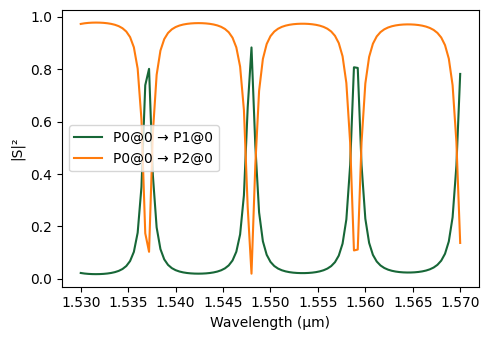

In [9]:
s_matrix = component.s_matrix(freqs, model_kwargs={"inputs": ["P0@0"]})
fig, ax = pf.plot_s_matrix(s_matrix, input_ports=["P0"], output_ports=["P1", "P2"])

In [ ]:
sim_data = component.active_model.batch_data_for(component)
_ = sim_data["P0@0"].plot_field("field", "E", val="abs^2", robust=False)

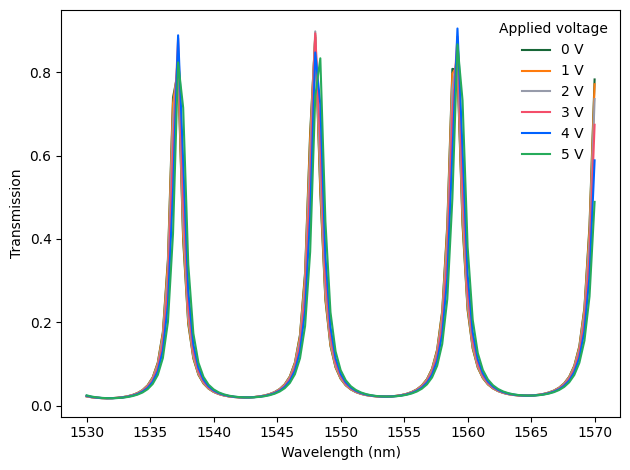

In [10]:
# the list of voltages
voltages = [0, 1, 2, 3, 4, 5]

# make one figure/axes
fig, ax = plt.subplots()

for v in voltages:
    updates = {("MRR_ps", 0): {"model_updates": {"voltage": v}}}
    s_matrix = component.s_matrix(freqs, model_kwargs={"updates": updates, "inputs": ["P0@0"]})
    s1 = s_matrix[("P0@0", "P1@0")]
    s2 = s_matrix[("P0@0", "P2@0")]
    ax.plot(
        wavelengths * 1e3,
        np.abs(s1) ** 2,
        label=f"{v} V",
        linewidth=1.5,
    )

# labels & legend
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transmission")
ax.legend(title="Applied voltage", loc="upper right", frameon=False)

plt.tight_layout()
plt.show()

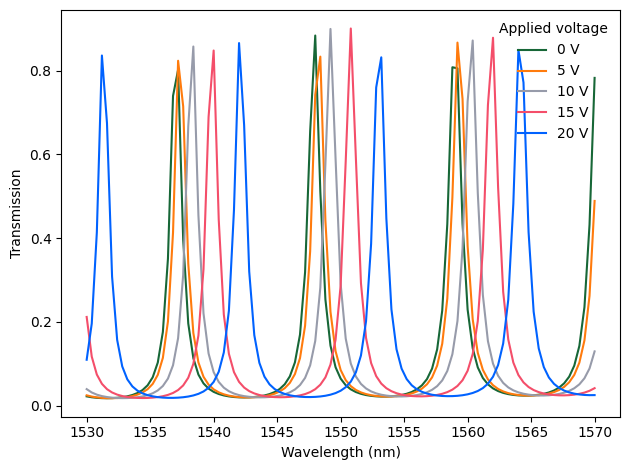

In [11]:
# the list of voltages
voltages = [0, 5, 10, 15, 20]

# make one figure/axes
fig, ax = plt.subplots()

for v in voltages:
    updates = {("MRR_ps", 0): {"model_updates": {"voltage": v}}}
    s_matrix = component.s_matrix(freqs, model_kwargs={"updates": updates, "inputs": ["P0@0"]})
    s1 = s_matrix[("P0@0", "P1@0")]
    s2 = s_matrix[("P0@0", "P2@0")]
    ax.plot(
        wavelengths * 1e3,
        np.abs(s1) ** 2,
        label=f"{v} V",
        linewidth=1.5,
    )

# labels & legend
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transmission")
ax.legend(title="Applied voltage", loc="upper right", frameon=False)

plt.tight_layout()
plt.show()

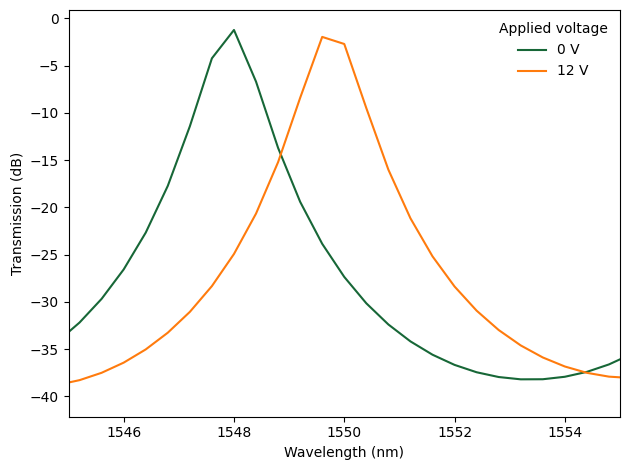

In [12]:
# the list of voltages
voltages = [0, 12]

# make one figure/axes
fig, ax = plt.subplots()

for v in voltages:
    updates = {("MRR_ps", 0): {"model_updates": {"voltage": v}}}
    s_matrix = component.s_matrix(freqs, model_kwargs={"updates": updates, "inputs": ["P0@0"]})
    s1 = s_matrix[("P0@0", "P1@0")]
    s2 = s_matrix[("P0@0", "P2@0")]
    ax.plot(
        wavelengths * 1e3,
        10*np.log(np.abs(s1) ** 2),
        label=f"{v} V",
        linewidth=1.5,
    )

# labels & legend
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transmission (dB)")
ax.legend(title="Applied voltage", loc="upper right", frameon=False)

ax.set_xbound(1545, 1555)

plt.tight_layout()
plt.show()